#### Materials to stady:

https://www.youtube.com/watch?v=1X93H_0_W5k&list=PLd3hlSJsX_ImKP68wfKZJVIPTd8Ie5u-9&index=14&t=4457s

http://www.cs.cmu.edu/~16385/s17/Slides/12.4_8Point_Algorithm.pdf

http://www.cse.psu.edu/~rtc12/CSE486/lecture20_6pp.pdf

https://github.com/marktao99/python/blob/master/CVP/samples/sfm.py

epipolar lines
http://www.cse.psu.edu/~rtc12/CSE486/lecture19.pdf

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
# number of points
N = 8

In [3]:
def cv2_imshow(img):
    plt.rcParams['figure.figsize'] = [20, 20]
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.axis("off")
    plt.show()

In [4]:
# simle function to measure error
def verify_f(pts1, pts2, F):
    points1 = np.vstack((pts1.T, np.ones(len(pts1)))).T
    points2 = np.vstack((pts2.T, np.ones(len(pts2)))).T
    
    # verify
    print('Should be close to 0:')
    total_error = 0
    for i in range(len(points1)):
        error = points2[i].dot(F.dot(points1[i]))
        print(error)
        total_error += abs(error)
        
    return total_error

In [17]:
# my implemention to draw epipolar lines
def epipolar_line(point1, F, img2):
    line2 = F.dot(point1)
    a, b, c = line2
    
    # ax + by + c = 0
    # y = (ax + c) / -b
    
    x1 = 0
    y1 = (a * x1 + c) / -b
    
    x2 = img2.shape[0]
    y2 = (a * x2 + c) / -b
    
    print(x1,y1,x2,y2)
    
    return cv2.line(img2, (int(x1), int(y1)), (int(x2), int(y2)), (100,255,100), 4)

In [18]:
# opencv to verify results

def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

def show_result(img1,img2,pts1,pts2, F):
    # Find epilines corresponding to points in right image (second image) and
    # drawing its lines on left image
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
    lines1 = lines1.reshape(-1,3)
    img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image
    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
    lines2 = lines2.reshape(-1,3)
    img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

    plt.rcParams['figure.figsize'] = [30, 30]
    plt.subplot(121),plt.imshow(img5)
    plt.subplot(122),plt.imshow(img6)
    plt.show()

    plt.rcParams['figure.figsize'] = [30, 30]
    plt.subplot(121),plt.imshow(img3)
    plt.subplot(122),plt.imshow(img4)
    plt.show()

In [7]:
# my implementation to fin fundamental matrix
def compute_fundamental_matrix(pts1, pts2):
    # convert to homogeneous coordinates (add one more dimension of 1ns)
    points1 = np.vstack((pts1.T, np.ones(len(pts1)))).T
    points2 = np.vstack((pts2.T, np.ones(len(pts2)))).T

    # normalize points
    mean1 = np.mean(points1, axis=0)
    std1 = np.std(points1, axis=0)
    T1 = np.array([
        [1/std1[0], 0, -mean1[0] / std1[0]],
        [0, 1/std1[1], -mean1[1] / std1[1]],
        [0, 0, 1]
    ])

    mean2 = np.mean(points2, axis=0)
    std2 = np.std(points2, axis=0)
    T2 = np.array([
        [1/std2[0], 0, -mean2[0] / std2[0]],
        [0, 1/std2[1], -mean2[1] / std2[1]],
        [0, 0, 1]
    ])

    points1n = T1.dot(points1.T).T
    points2n = T2.dot(points2.T).T


    # create matrix A
    A = np.ones((N,9))
    for i in range(N):  
        A[i] = [
            points1n[i,0]*points2n[i,0], points1n[i,0]*points2n[i,1], points1n[i,0],
            points1n[i,1]*points2n[i,0], points1n[i,1]*points2n[i,1], points1n[i,1],
            points2n[i,0], points2n[i,1], 1
        ]
        
    # find the smallest eigen vector
    u, s, vh = np.linalg.svd(A)
    F = vh[-1].reshape(3,3)

    # normalize
    F = F / np.linalg.norm(F)

    # make rank 2
    u, s, vh = np.linalg.svd(F)
    s[2] = 0
    F2 = u.dot(np.diag(s).dot(vh))

    # denormalize
    F = T2.T.dot(F2.dot(T1))
    
    return F

In [19]:
# simple test
pts1 = np.random.randint(100, size=(8, 2))
pts2 = np.random.randint(100, size=(8, 2))

In [20]:
F = compute_fundamental_matrix(pts1, pts2)
print(F)

# verify
print('Total error: ', verify_f(pts1, pts2, F))

[[-1.59429380e-03  1.35047378e-04  6.25459109e-02]
 [ 3.09874384e-04  1.14804699e-04 -1.63098218e-02]
 [ 4.05538676e-02 -1.44287753e-02 -1.26728266e+00]]
Should be close to 0:
-1.6112637105366692
1.3679000336132834
0.2507213670479622
0.09857192725255148
0.36799870749590724
0.0036757014667369026
-0.5071001119161014
-0.4045077262345873
Total error:  4.611739285563798


In [21]:
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
print(F)

# verify
print('Total error: ', verify_f(pts1, pts2, F))

[[ 2.68782983e-03 -9.71607170e-04 -7.65993398e-02]
 [-1.41172407e-03 -1.41428676e-04  7.27822025e-02]
 [-1.01988254e-01  7.50410315e-02  1.00000000e+00]]
Should be close to 0:
8.881784197001252e-16
-1.3322676295501878e-15
1.3322676295501878e-15
-8.881784197001252e-16
0.0
6.661338147750939e-16
3.442993687089779
-6.106226635438361e-16
Total error:  3.442993687089784


0 -21.100870251689614 100 94.85753174715315


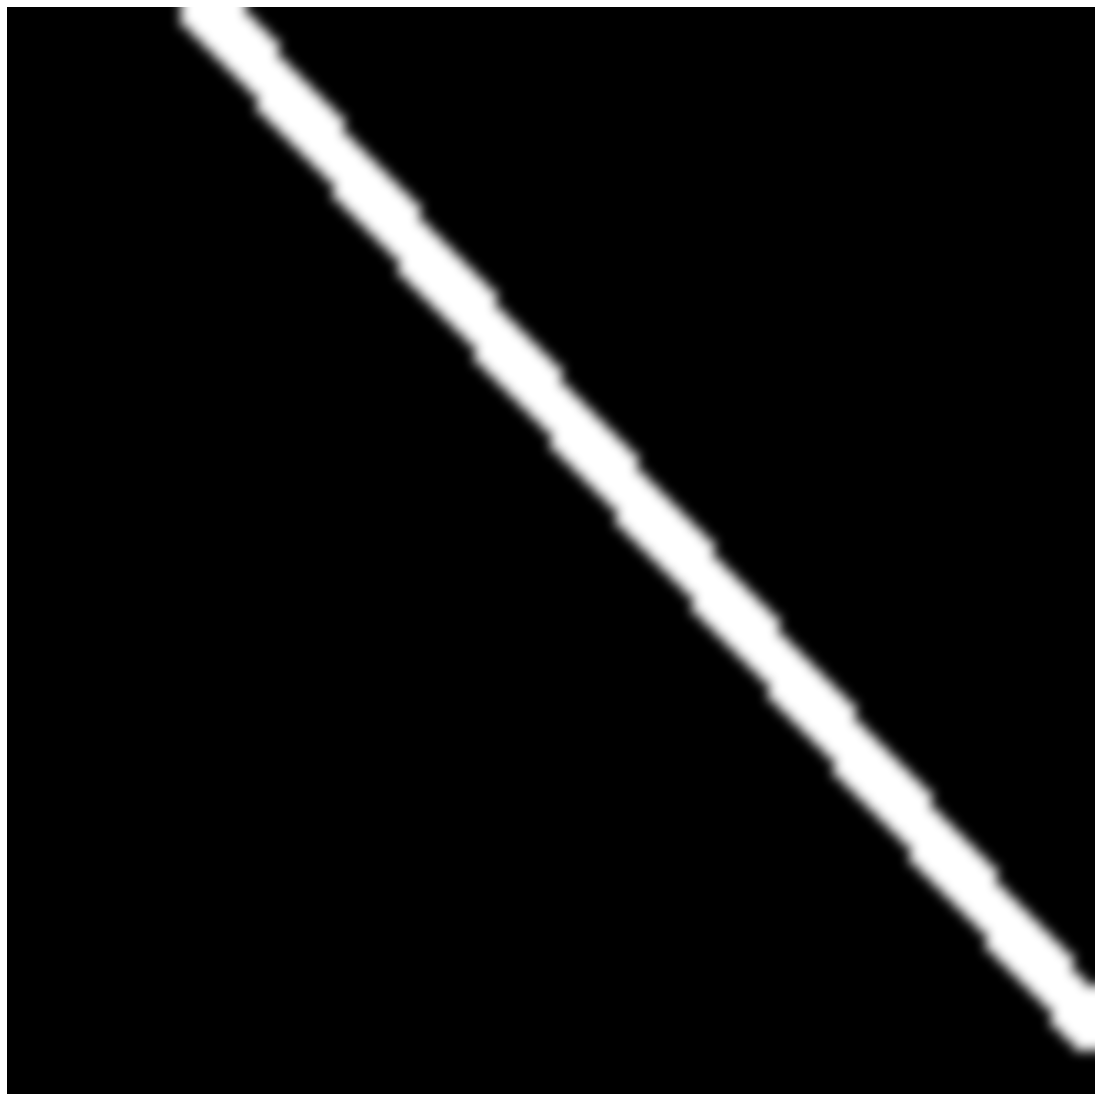

In [22]:
img = np.zeros((100,100))
img = epipolar_line((25,30,1), F, img)

cv2_imshow(img)

### Verify on real images

In [25]:
# I did not have possibility to make a pictures of UKU
# I made these a photos in my appartments

img1 = cv2.imread('data/l6.jpg',0)
img2 = cv2.imread('data/r6.jpg',0)

# decrease the size of images
img1 = cv2.resize(img1, None,fx=1/8, fy=1/8, interpolation = cv2.INTER_CUBIC)
img2 = cv2.resize(img2, None,fx=1/8, fy=1/8, interpolation = cv2.INTER_CUBIC)

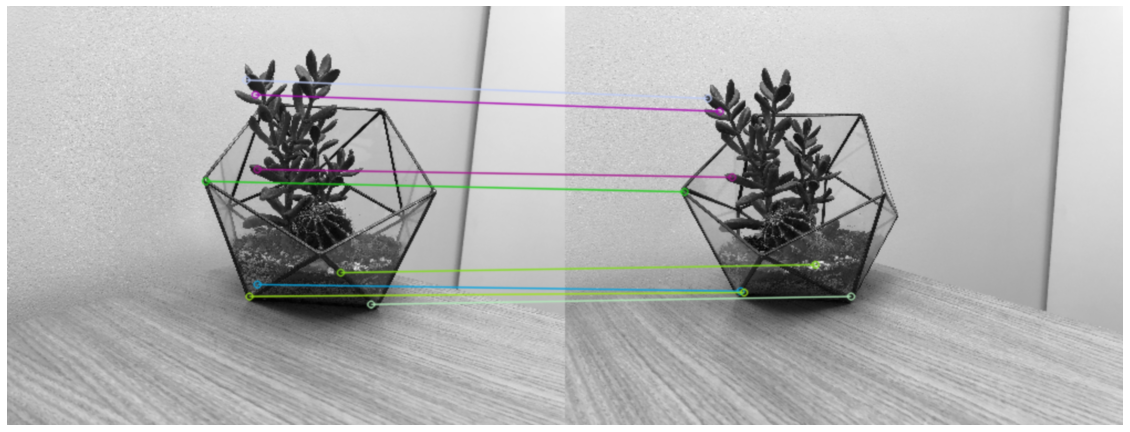

In [26]:
# find a key points
orb = cv2.ORB_create(nfeatures=1500)

kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

good = []
pts1 = []
pts2 = []

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first N matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:N],None, flags=2)
cv2_imshow(img3)

for i, m in enumerate(matches[:N]):
    good.append(m)
    pts2.append(kp2[m.trainIdx].pt)
    pts1.append(kp1[m.queryIdx].pt)
    
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

[[ 6.28752103e-06  1.21852780e-04 -2.35505053e-02]
 [-1.38979427e-04  1.90397188e-05  3.80232523e-02]
 [ 2.43700660e-02 -3.04496836e-02 -1.84444422e+00]]
Should be close to 0:
0.21679567699455848
0.07280361123209467
0.28940570269873334
0.3329281899243961
0.07929646410317037
0.009403507055034233
0.24628284779550413
0.34416338972387917
Total error:  1.5910793895273705


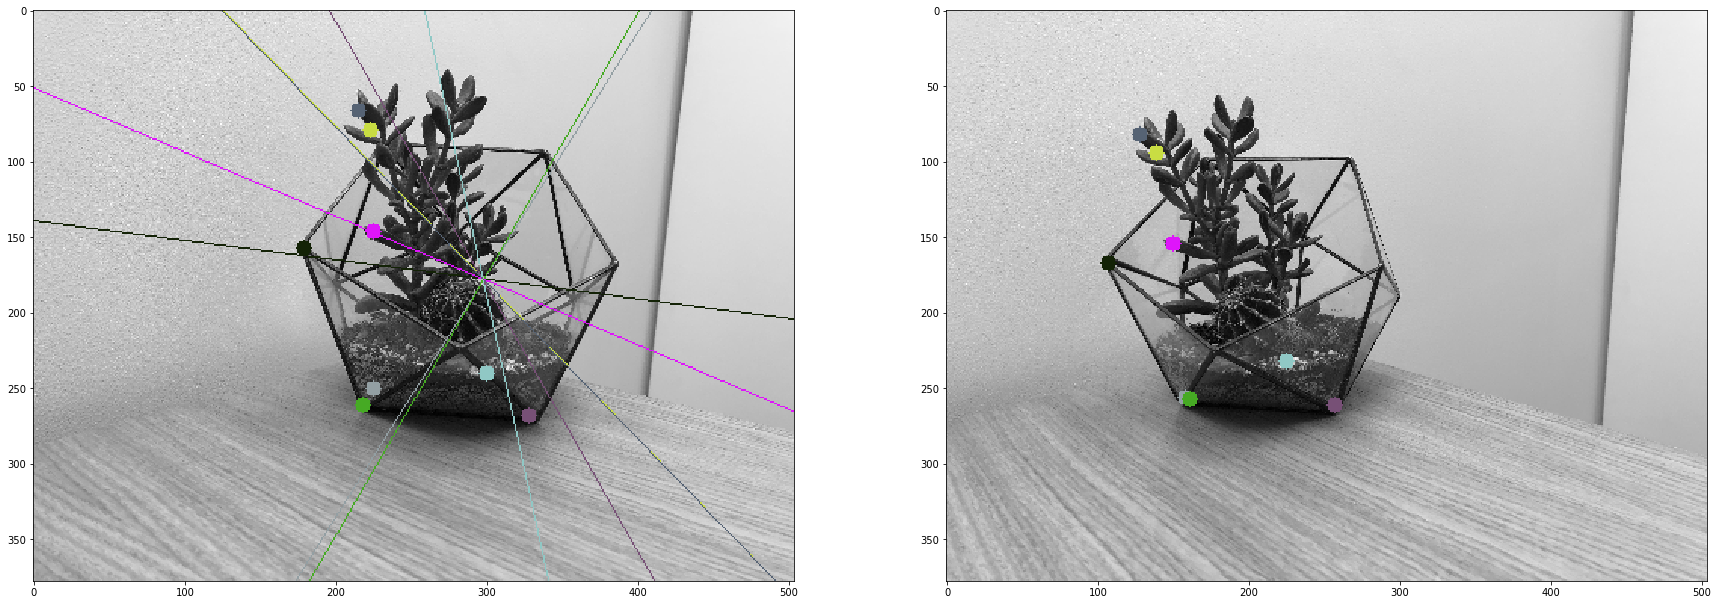

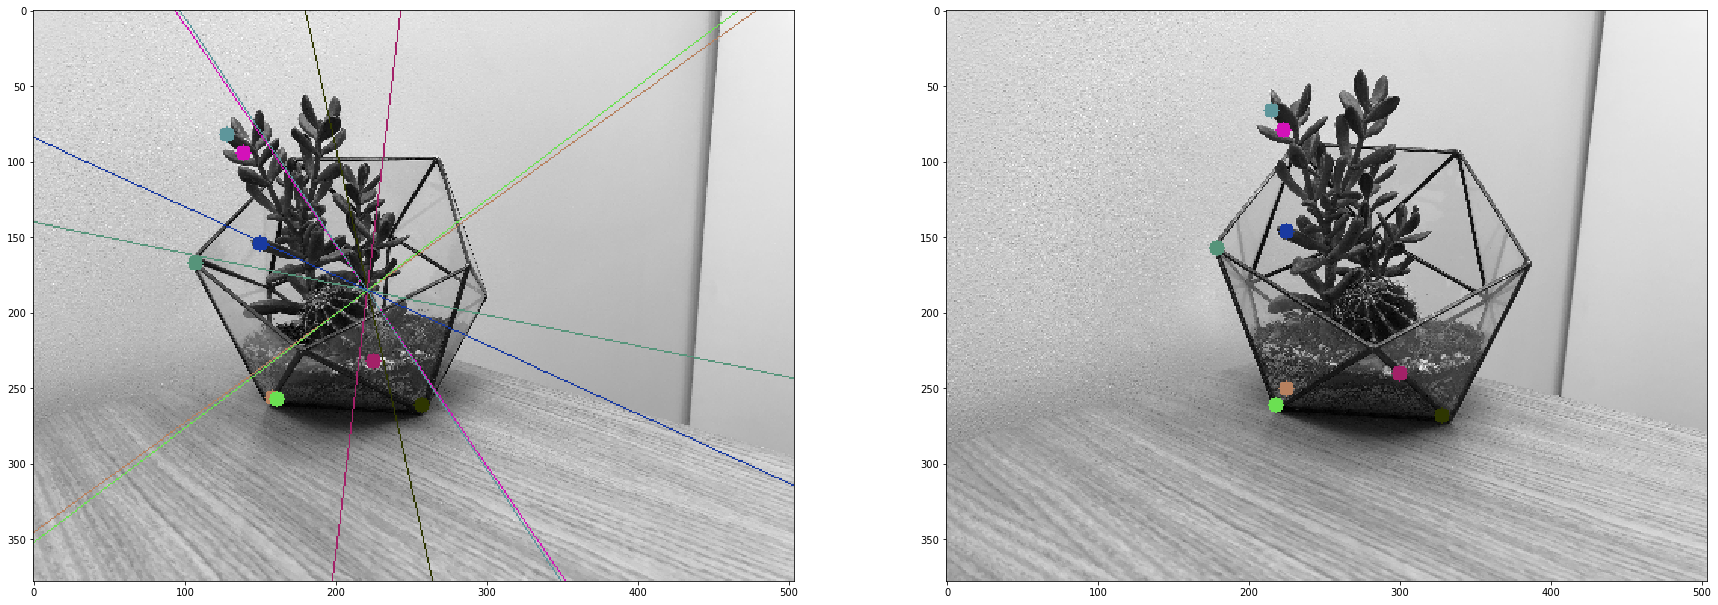

In [14]:
F = compute_fundamental_matrix(pts1, pts2)
print(F)

# verify
print('Total error: ', verify_f(pts1, pts2, F))

show_result(img1,img2,pts1,pts2, F)

0 -817.9290155890249 378 898.6328960249551
0 2048.3169234089264 378 -1139.1532826067214
0 345.14596649356355 378 71.73312062439095
0 352.8239940938096 378 66.27435021322245
0 140.24039615552084 378 217.41278246997675
0 84.63865021201937 378 256.94339910333815
0 -138.7883467149844 378 415.7910541758839
0 -147.39834644454788 378 421.9124194810054


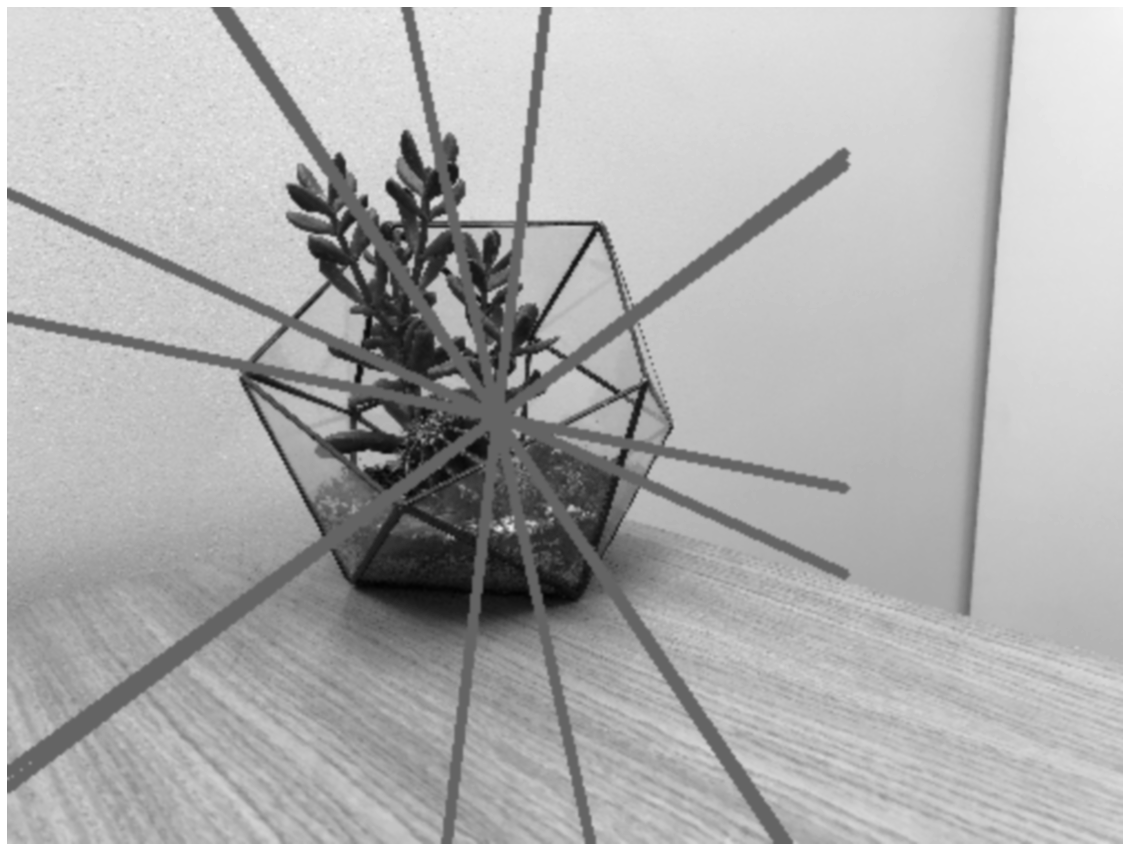

0 485.0515679382102 378 -27.734164111379236
0 306.66754846827723 378 99.08973624508423
0 276.47852296574615 378 120.5529254565881
0 279.7573622915477 378 118.22180188859151
0 164.13223832071503 378 200.42663864893964
0 143.13310519441225 378 215.3561820861601
0 64.37107856838614 378 271.3528315975583
0 56.06523696315933 378 277.257952646226


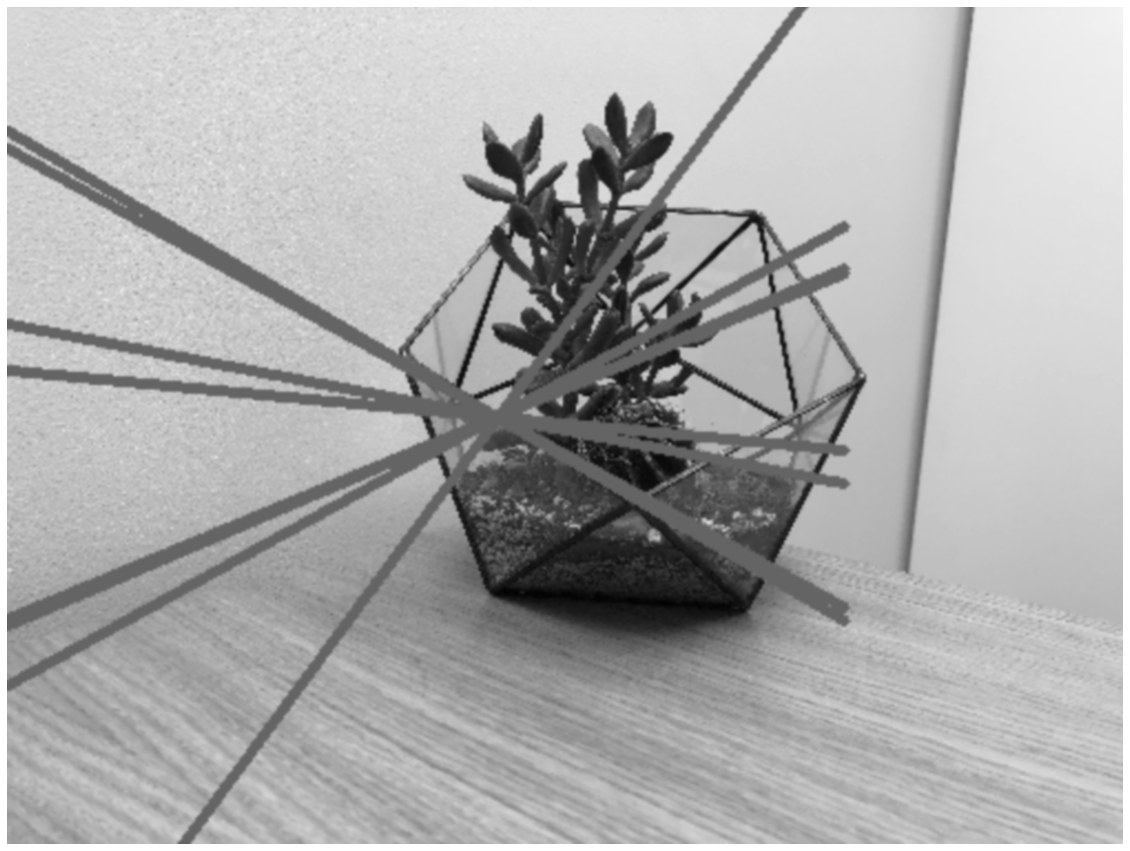

In [15]:
img3 = np.copy(img2)
points1 = np.vstack((pts1.T, np.ones(len(pts1)))).T
for point in points1:
    epipolar_line(point, F, img3)
cv2_imshow(img3)  

img3 = np.copy(img1)
points2 = np.vstack((pts2.T, np.ones(len(pts2)))).T
for point in points2:
    epipolar_line(point, F, img3)
cv2_imshow(img3)    

[[-2.11290395e-07 -8.04056785e-05  7.00402510e-03]
 [ 7.04613021e-05  1.28907278e-05 -2.93629952e-02]
 [-7.03837280e-03  2.11755312e-02  1.00000000e+00]]
Should be close to 0:
-0.11935190365357862
-5.329070518200751e-15
-2.6645352591003757e-15
-1.7763568394002505e-15
-8.881784197001252e-16
-1.7763568394002505e-15
2.220446049250313e-16
-1.1102230246251565e-16
Total error:  0.11935190365359138


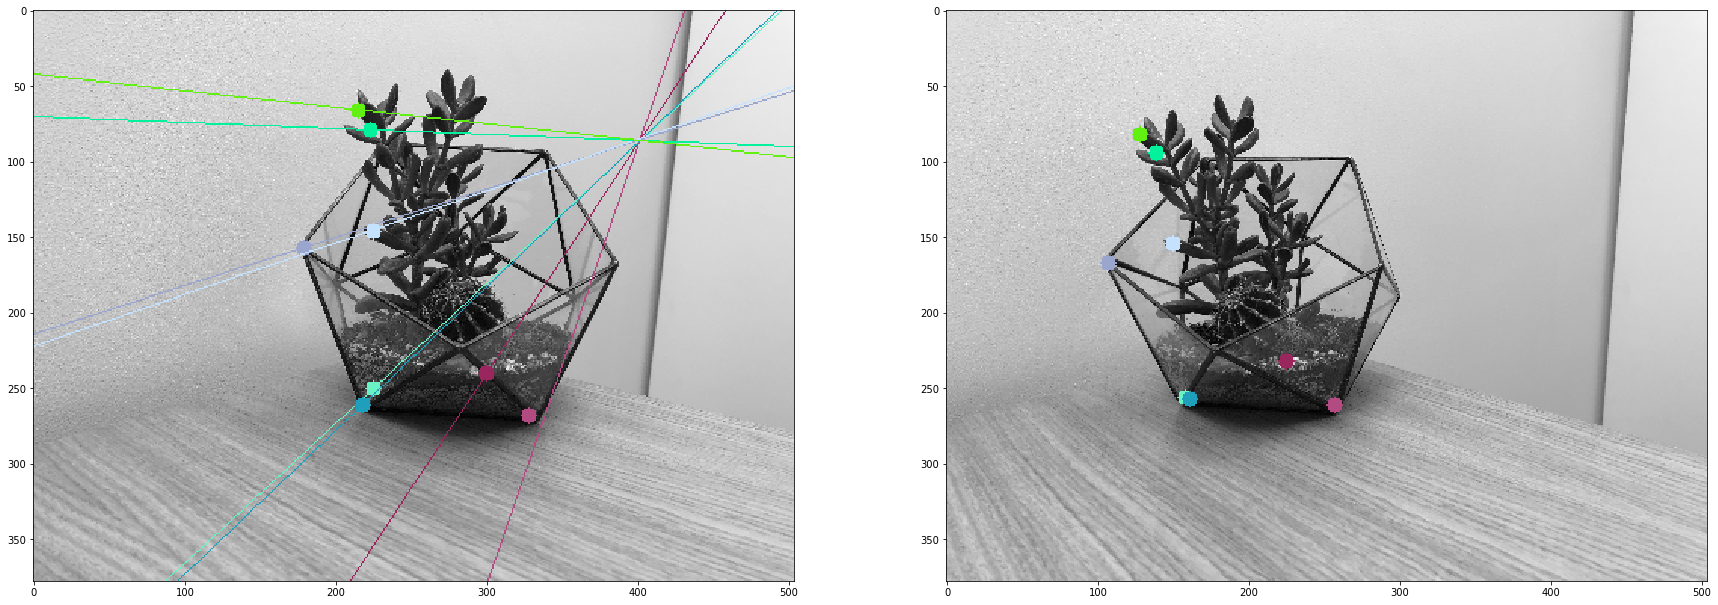

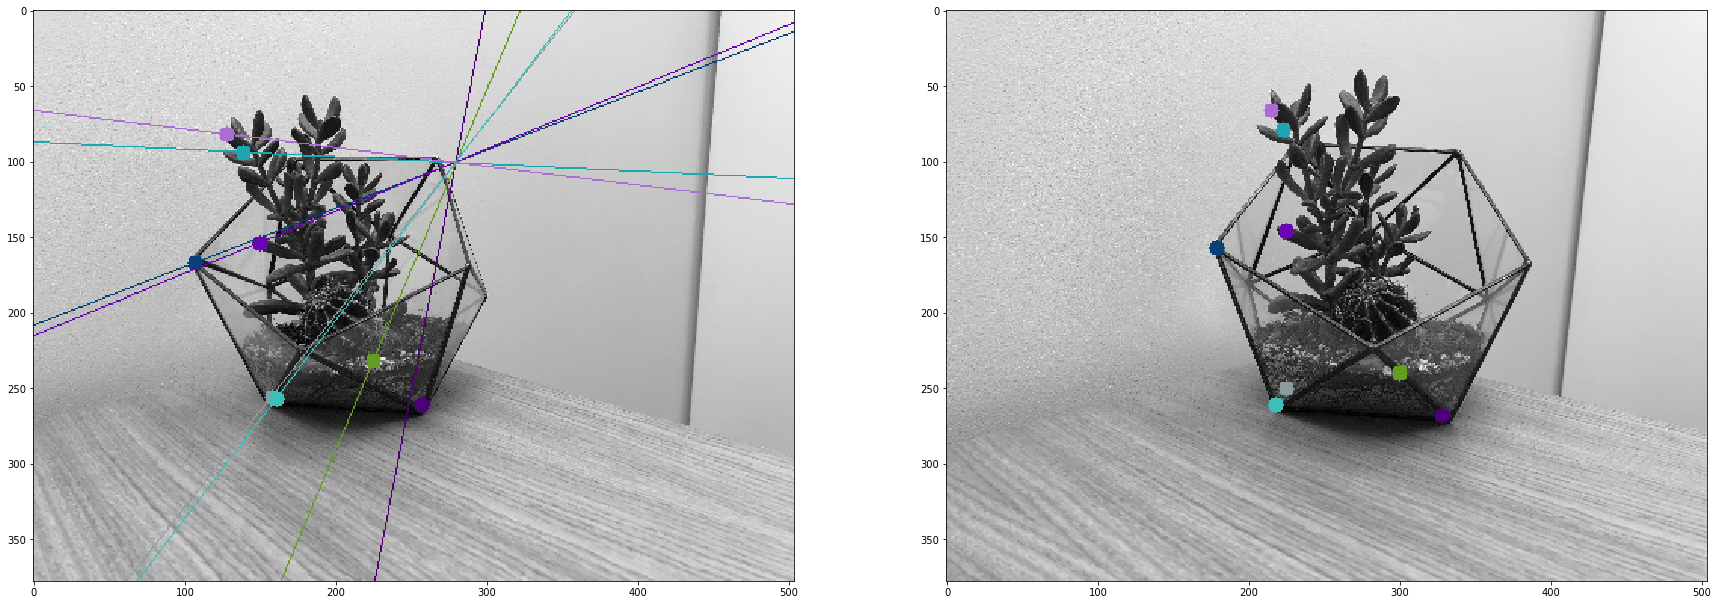

In [16]:
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
print(F)

# verify
print('Total error: ', verify_f(pts1, pts2, F))


show_result(img1,img2,pts1,pts2, F)